## 3D segmentation of lumen (apical surface) and basal surface using LifeactRFP (LARFP) signal
#### INPUTS:
    image stack
    time point to segment

#### OUTPUTS:
    segmented stacks for each time point of lumen
    note: you may have to manually segment a couple of slices using the polygon tool in Fiji

@author: clauvasq & vipul

#### import packages and functions

In [20]:
import os
import numpy as np
import skimage.io as io
io.use_plugin('tifffile')
from skimage.filters import threshold_otsu, threshold_mean, median
from skimage import morphology
from skimage import measure
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from LARFP_lumen_segmentation_functions_CGV import *

#### specify input & output directories & dataset

In [21]:
input_dir = '/Users/clauvasq/Documents/Python/lumen_curvature_3D/input/'
output_home = '/Users/clauvasq/Documents/Python/lumen_curvature_3D/output/'

# root filename (no ".tif")
filename, timePt = '190418_09', 1
t = 0

#### make output directory

In [27]:
# make dataset directory, and seg subdirectory, if haven't already
make_dir = input('Have you analyzed this data set before? (y/n) ')
output_dir = output_home + filename

if make_dir == 'n':
    if t == 0:
        os.mkdir(output_dir)
        output_dir = output_dir + '/seg/'
        os.mkdir(output_dir)
else:
    output_dir = output_dir + '/seg/'

if timePt < 10:
    filename_t = filename + '_t0' + str(timePt)
else:
    filename_t = filename + '_t' + str(timePt)

Have you analyzed this data set before? (y/n) y


In [23]:
# load full image stack, choose z-stack for time point of interest
full_image = io.imread(input_dir + filename + '.tif')

if len(full_image.shape) == 3:
    z_stack = full_image.copy()
else:
    z_stack = full_image[timePt - 1]  # -1 b/c Python

#### LUMEN: initial segmentation
asks you if lumen is relatively round or squiggly to determine which segmentation strategy to use.

In [24]:
th_otsu = threshold_otsu(z_stack)
bin_stack = np.array(z_stack > th_otsu, dtype=np.uint8)
    
rnd_squ = input('Is the lumen relatively round? (y/n) ')

if rnd_squ == 'y':
    lumen_stack = otsu_morph_seg(bin_stack, opt=2)
else:
    lumen_stack = otsu_morph_seg(bin_stack, opt=3)

very_squ = input('Is the lumen really squiggly? (y/n) ')
if very_squ == 'y':
    med_stack = med_filter(z_stack, med_sel=3)
    th_otsu = threshold_otsu(med_stack)
    bin_stack = np.array(med_stack > th_otsu, dtype=np.uint8)
    lumen_stack = bin_stack.copy()
    for i in range(len(bin_stack)):
        z_slice = bin_stack[i, :, :]
        z_o = morphology.binary_opening(z_slice)
        lumen_stack[i, :, :] = z_o
else:
    pass

Is the lumen relatively round? (y/n) n
Is the lumen really squiggly? (y/n) y


#### CYST: initial segmentation

In [25]:
lat_edges = input('Are lateral cell edges thin & very bright? (y/n) ')
if lat_edges == 'y':
    cyst_stack = bgsub_zyx_morph(z_stack, opt=2)
else:
    cyst_stack = bgsub_zyx_morph(z_stack, opt=1)

Are lateral cell edges thin & very bright? (y/n) y


#### LUMEN: find largest contour(s) from segmentation

Are there multiple lumens? (y/n) n
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225


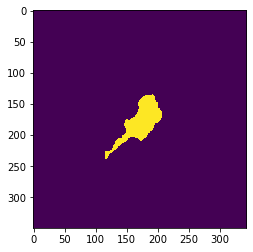

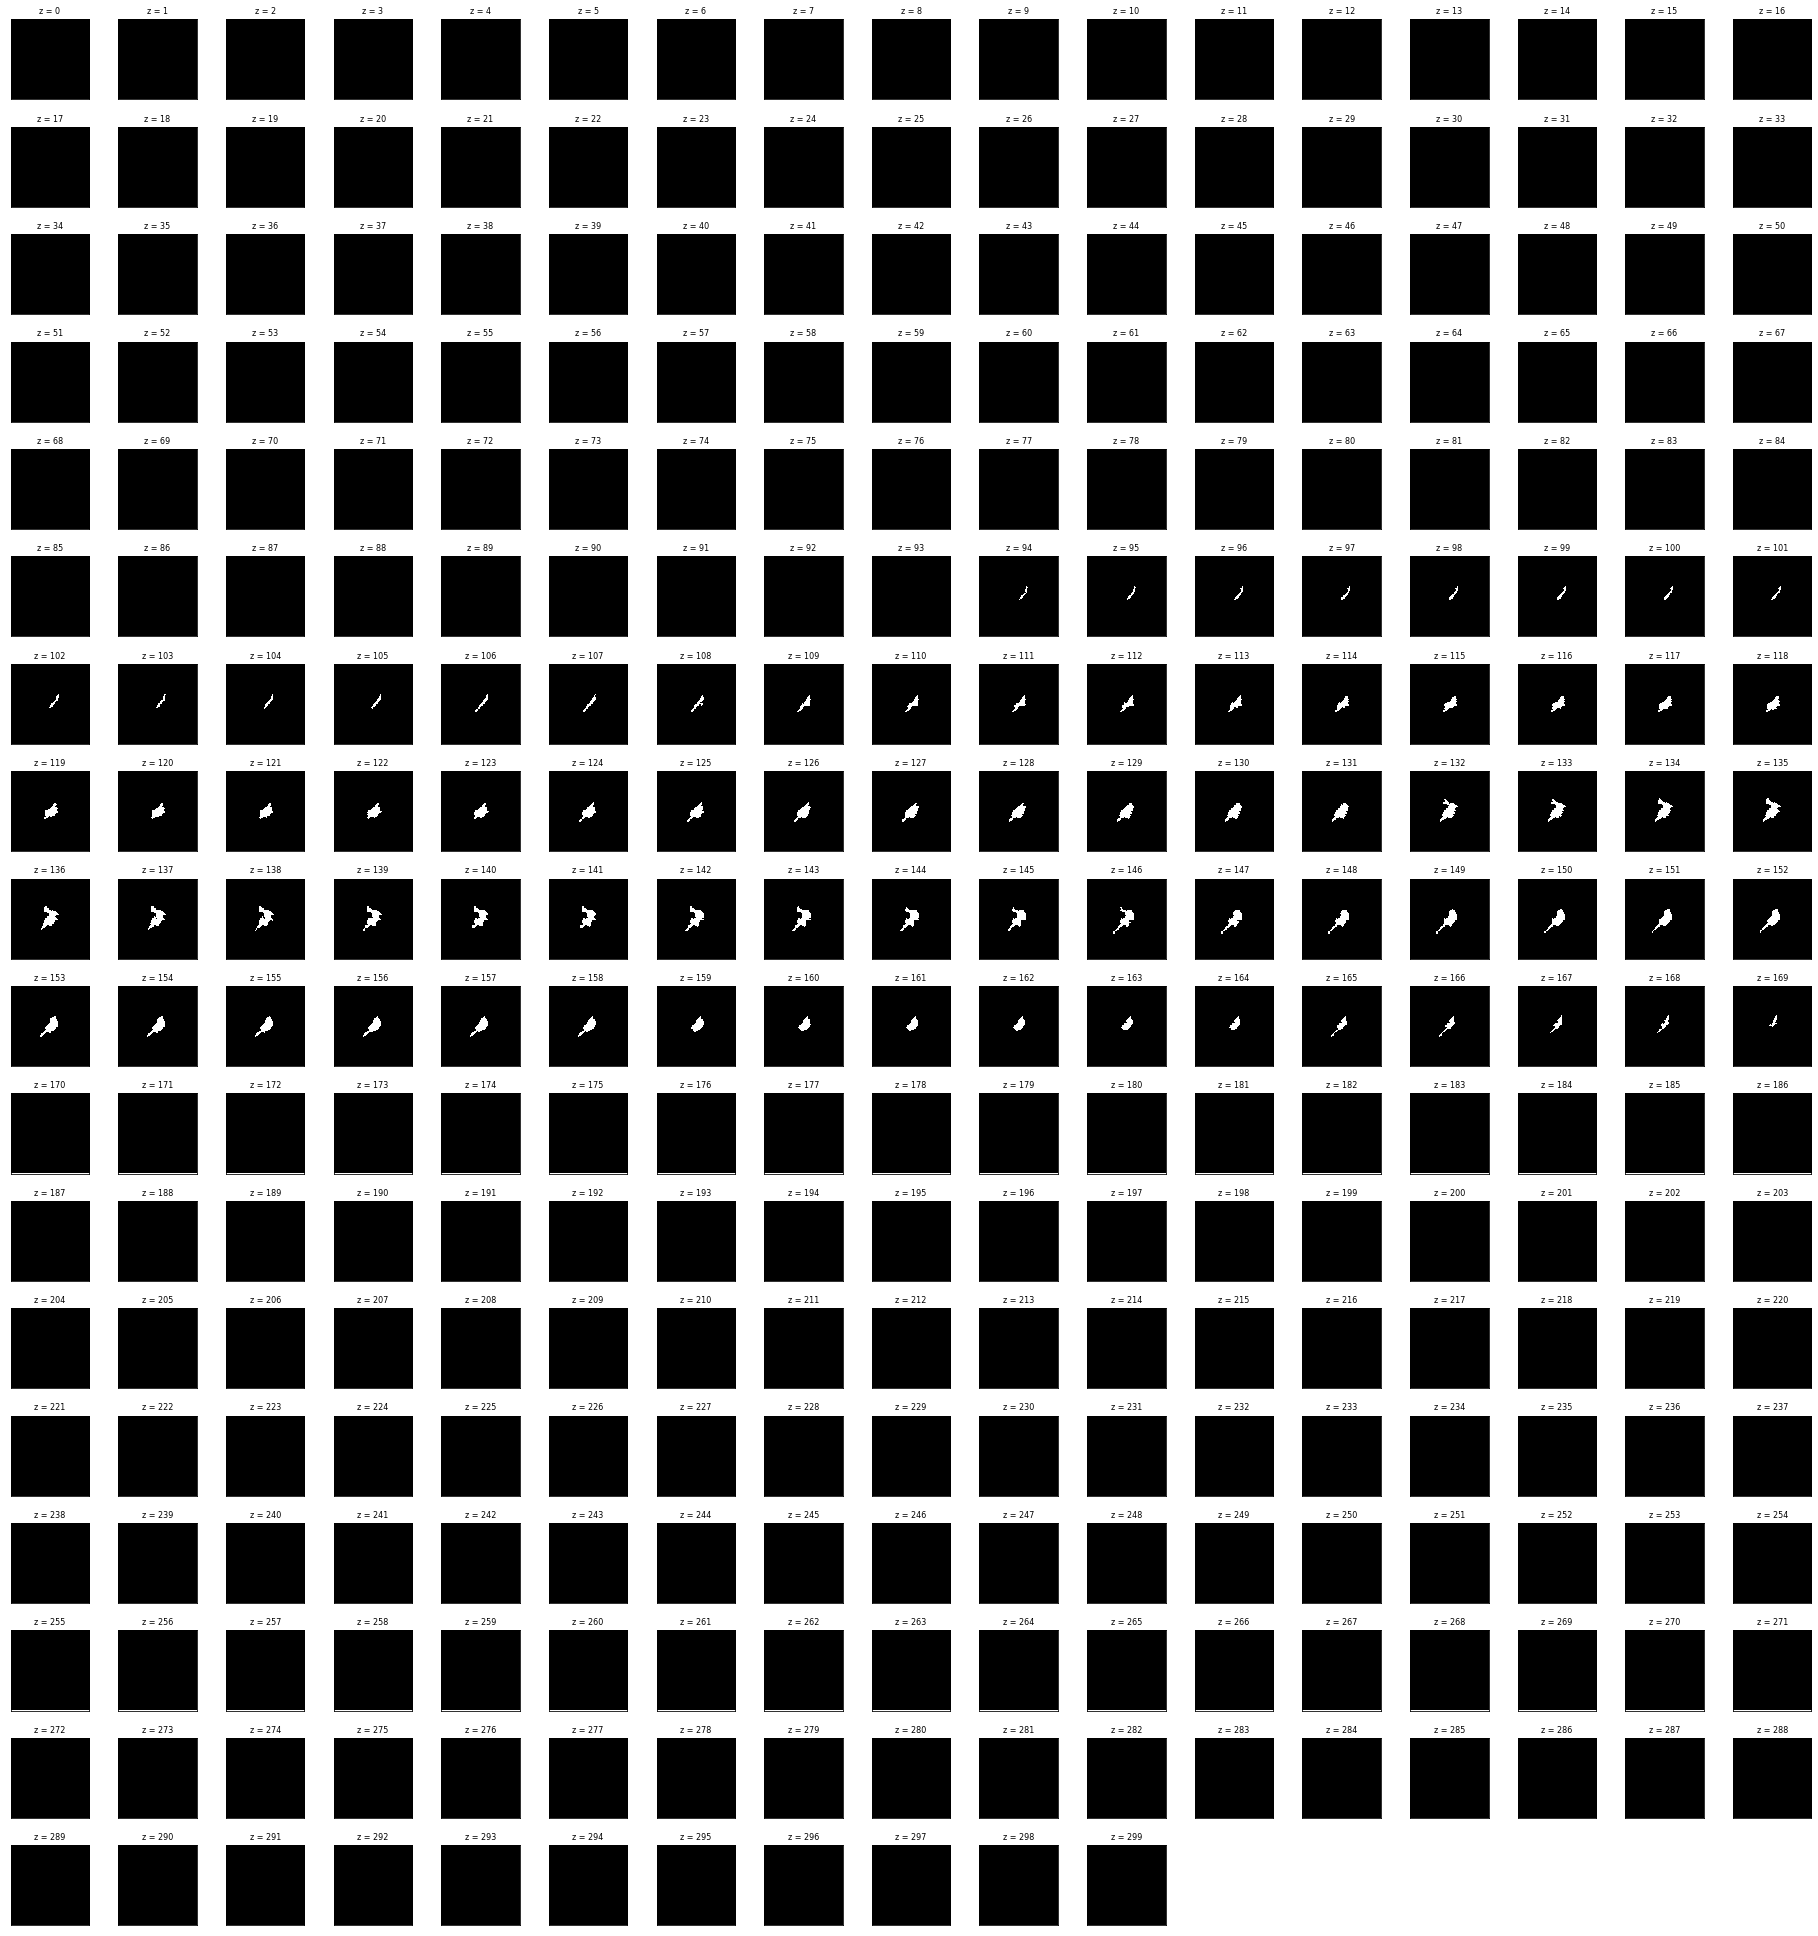

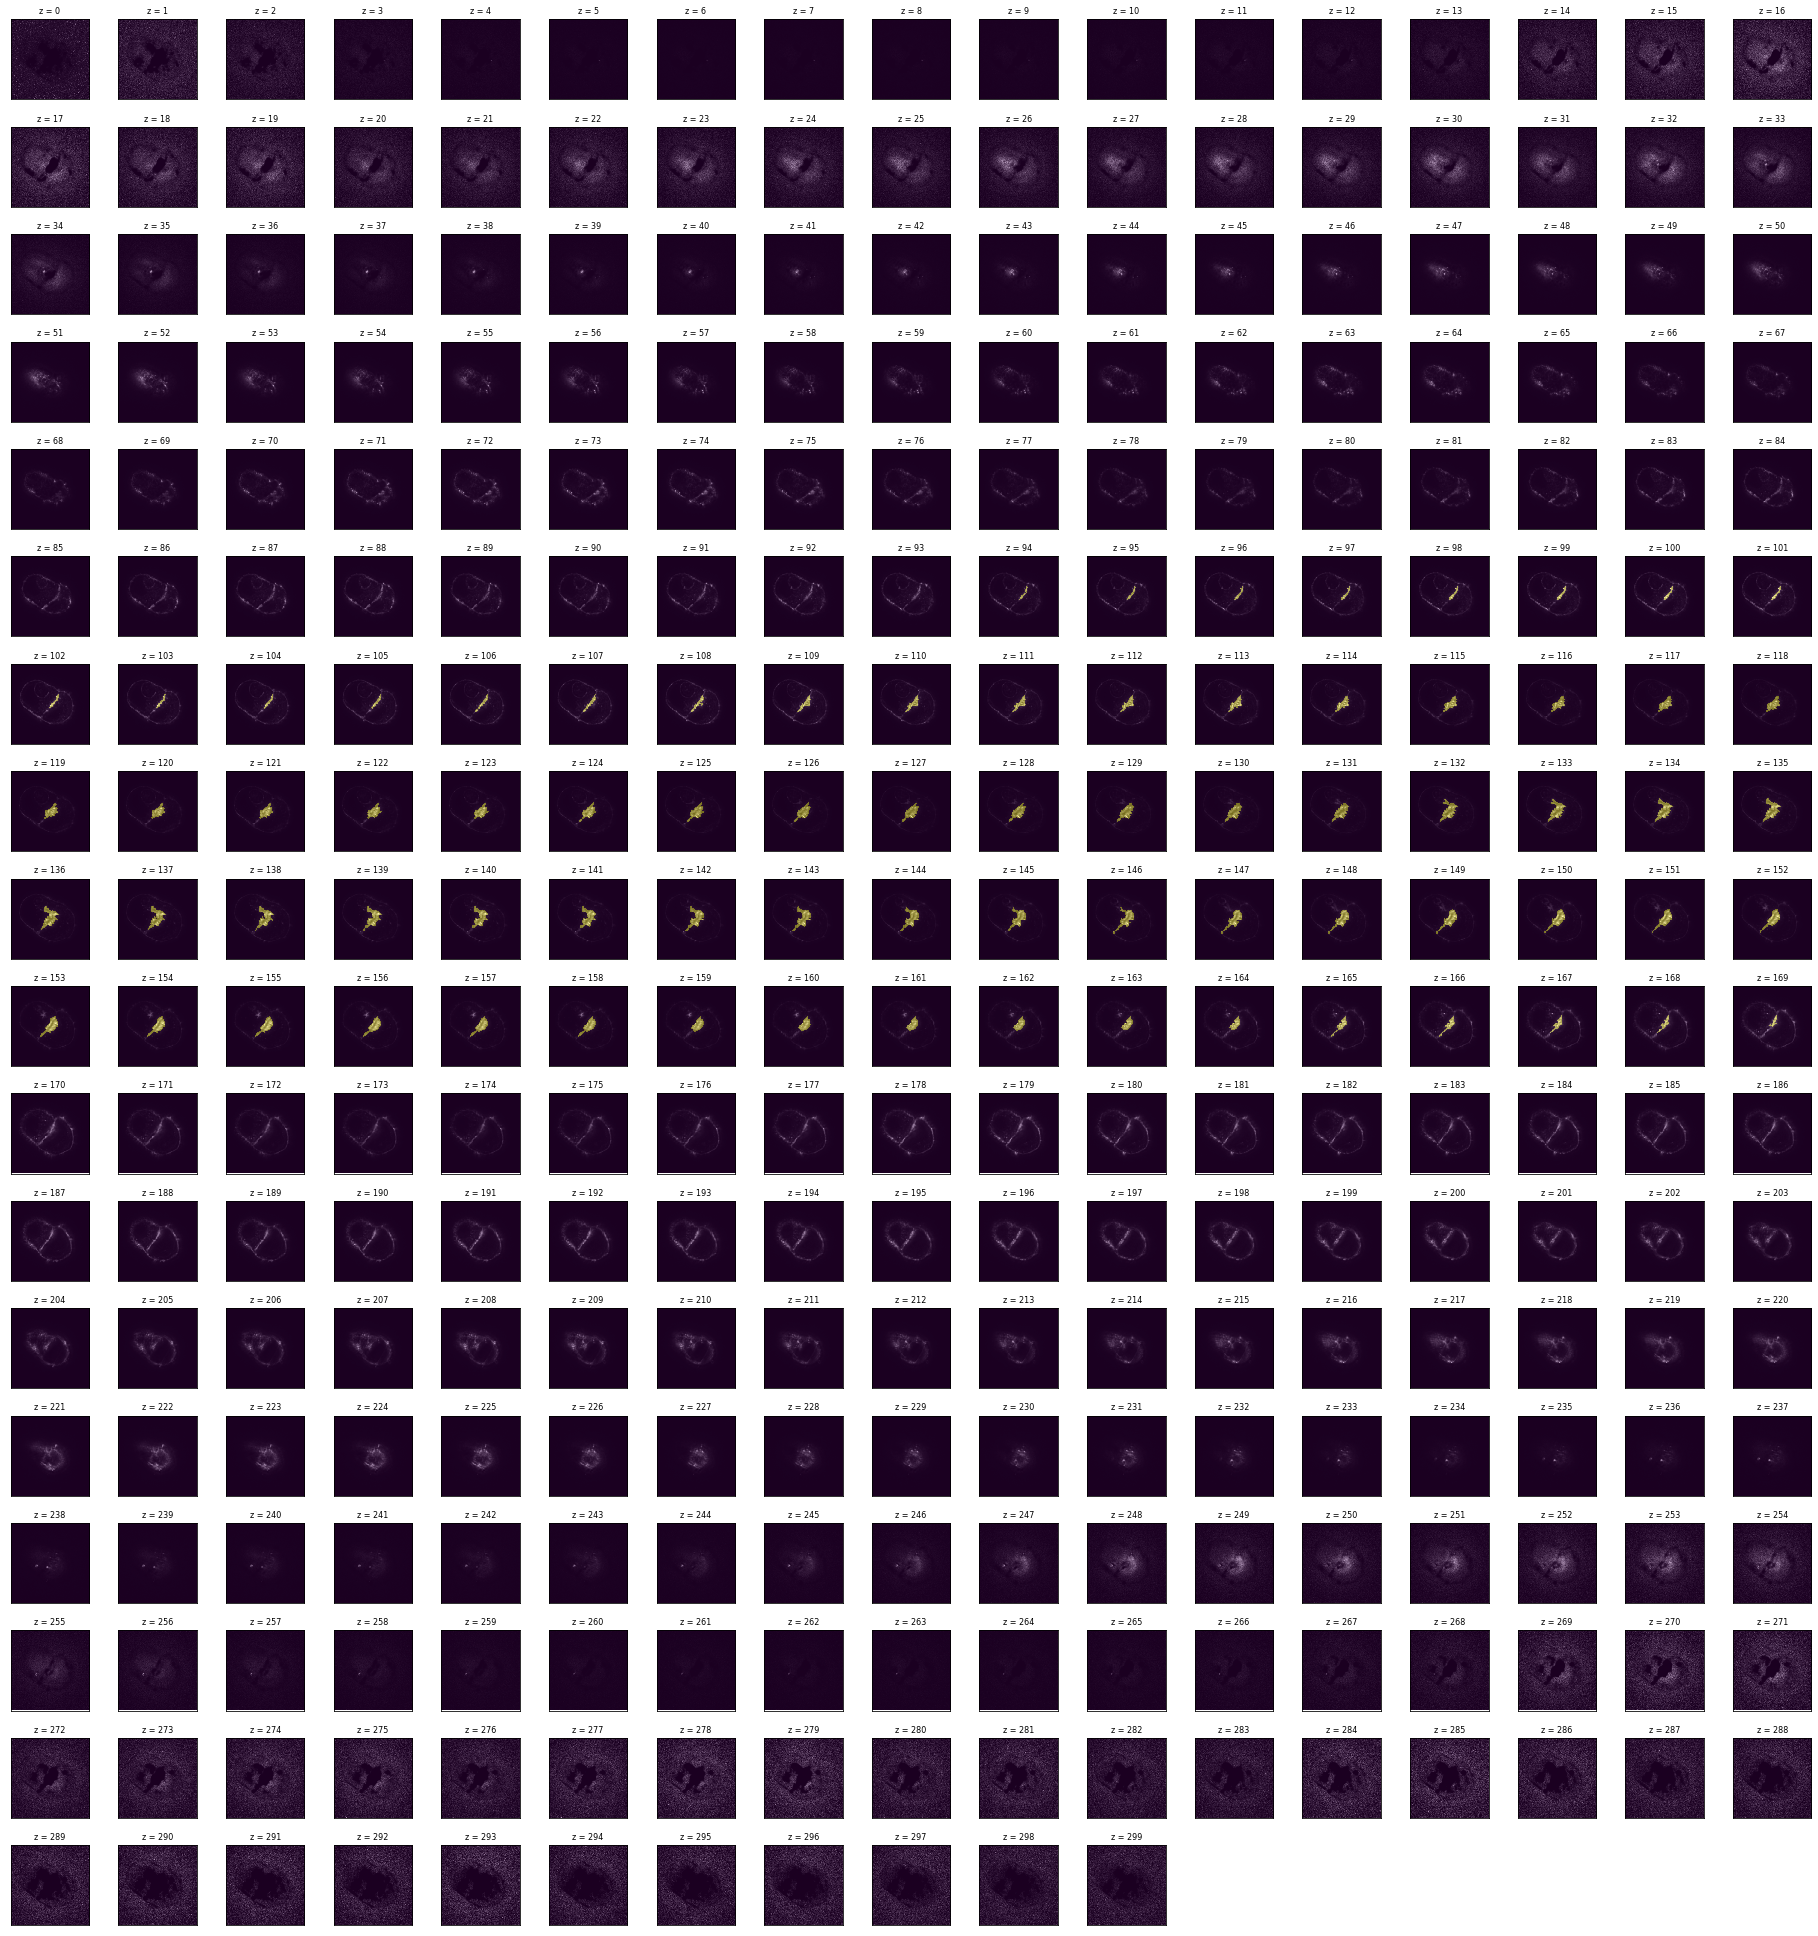

In [28]:
mult_lum = input('Are there multiple lumens? (y/n) ')
if mult_lum == 'n':
    lumen = lumen_contours(lumen_stack, longest=True)
else:
    # for multiple lumens run this
    lumen_test = lumen_contours_multiple(lumen_stack)
    lumen = lumen_test[0] + lumen_test[1] + lumen_test[2]
    lumen[lumen > 0] = 1
    
# check output of lumen segmentation, plot each z-slice of lumen contours, save as png in output_dir
_ = plot_stack_save(lumen, pw=output_dir, name=filename_t + '_segContours_CGV',
                subtitle=True)
_ = plot_stack_overlay(lumen, z_stack, pw=output_dir,
                   name=filename_t + '_segContours_overlay', subtitle=True)

#### CYST: find largest contour from segmentation

25
26
27
28
29
32
35
36
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251


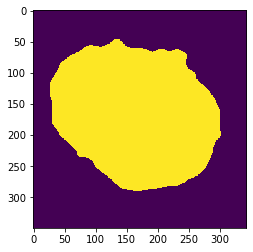

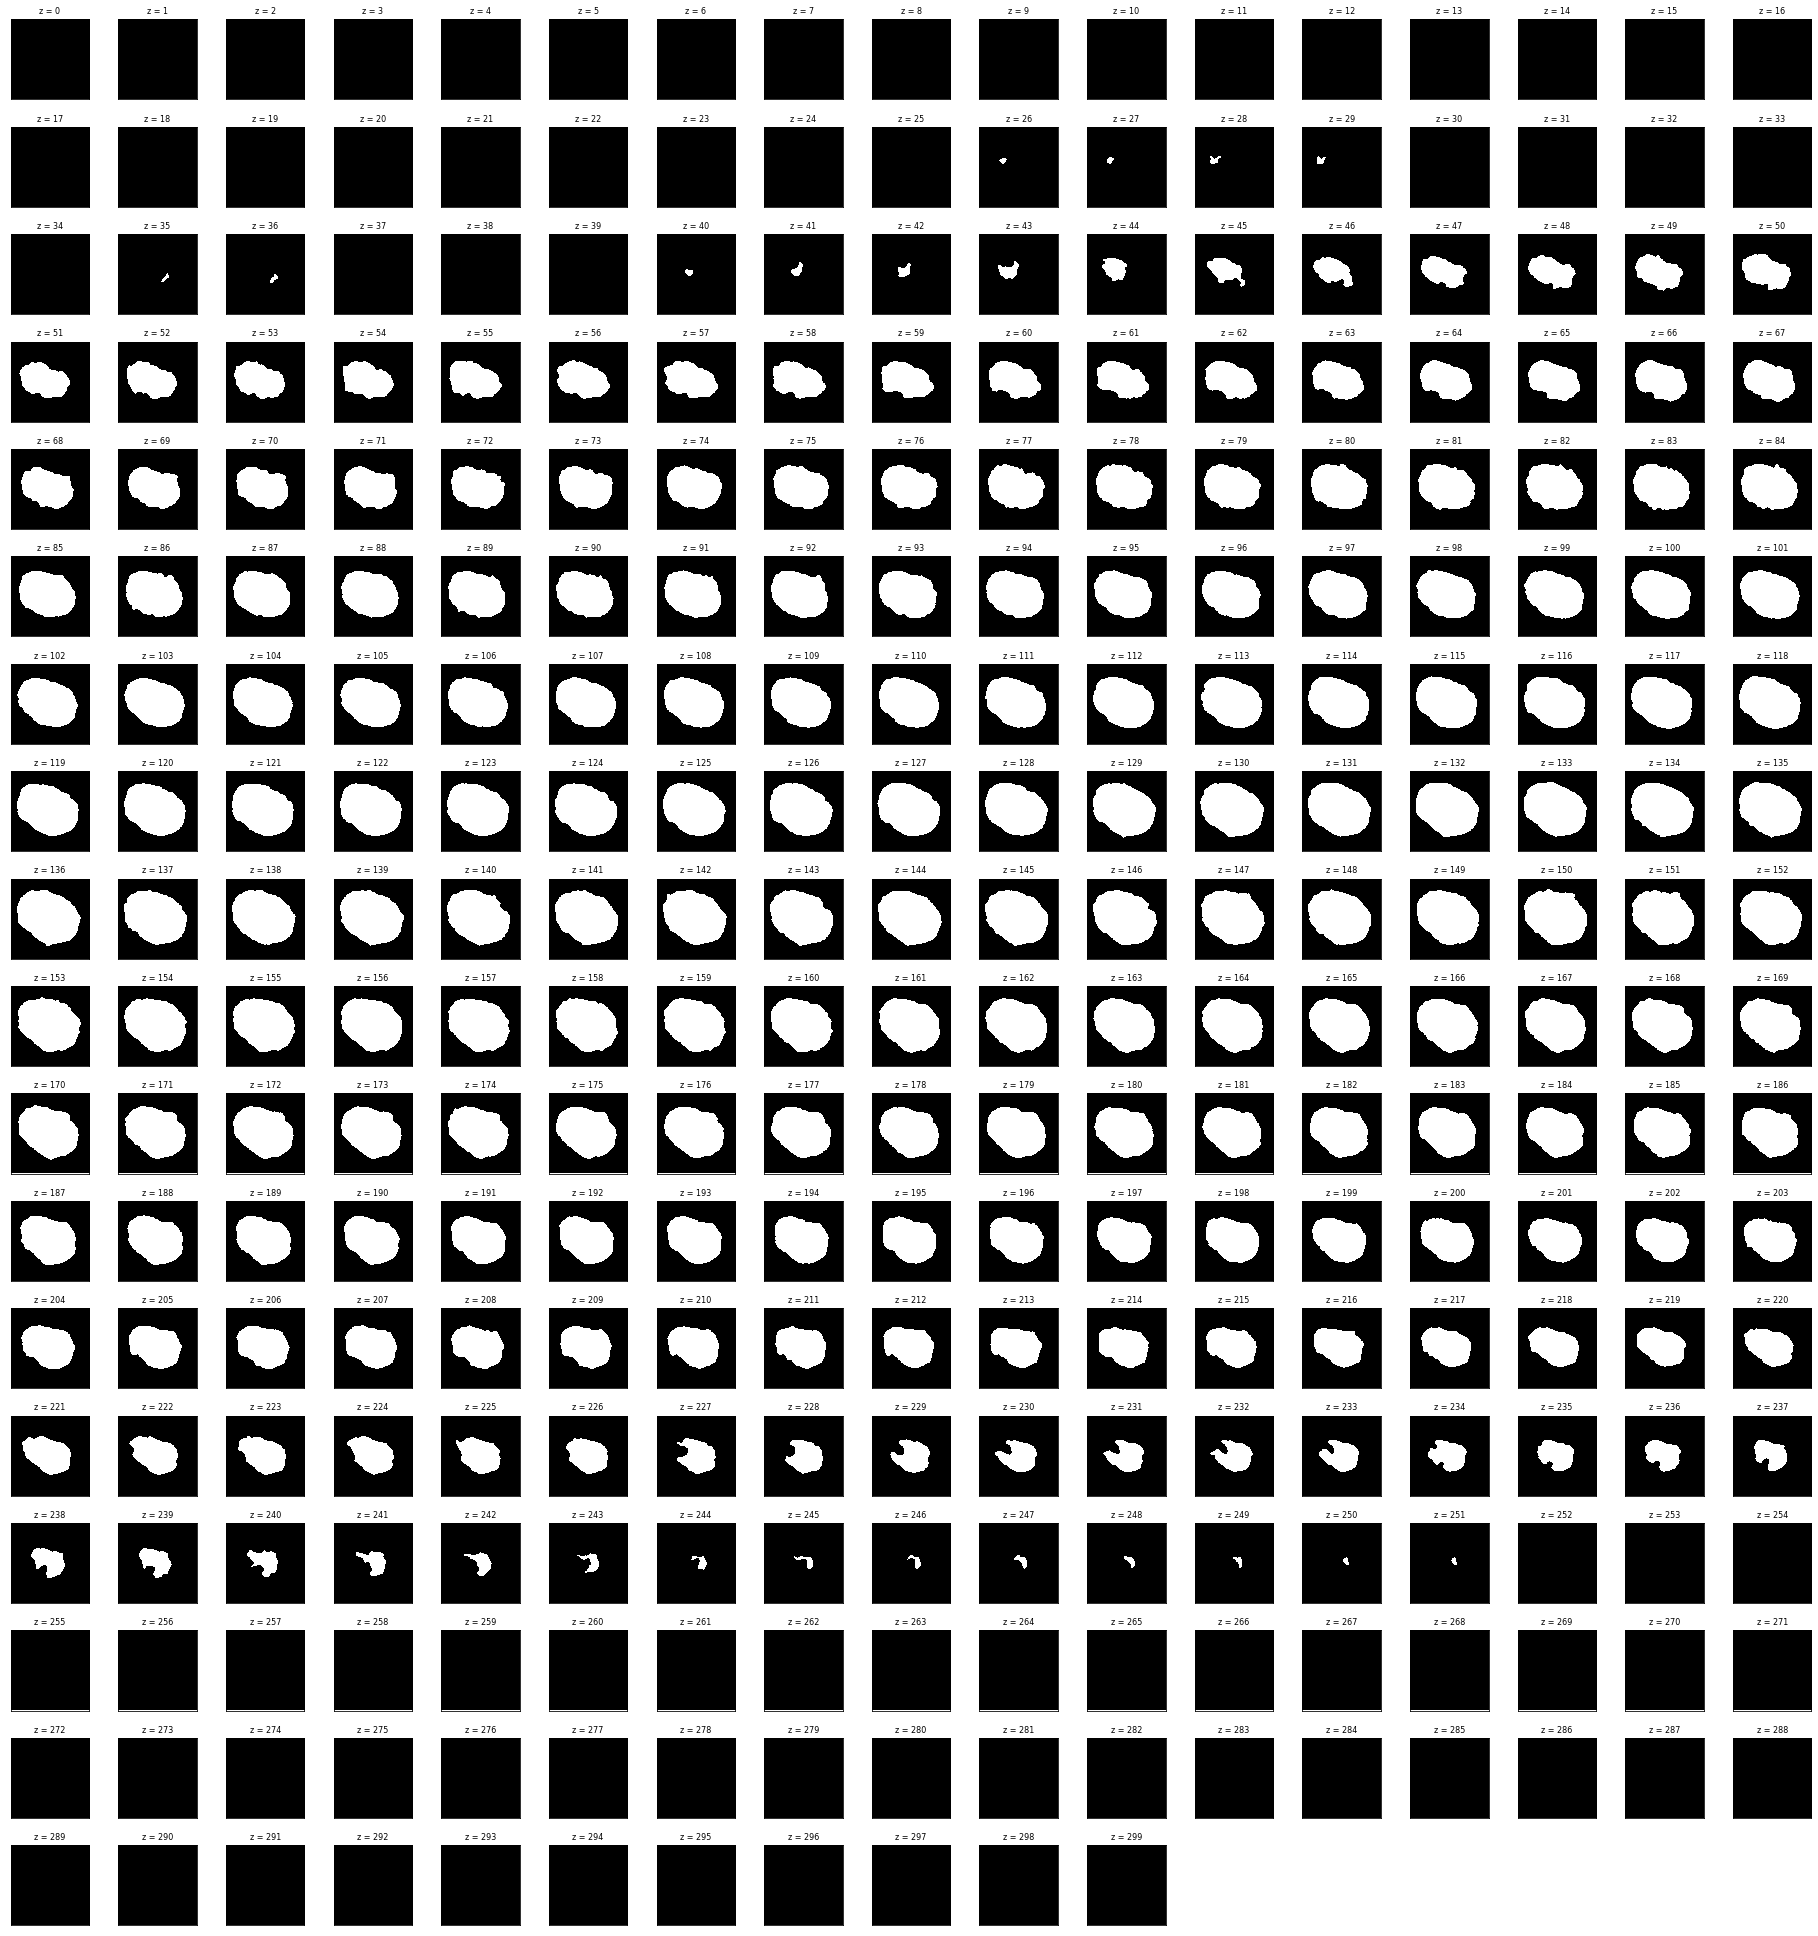

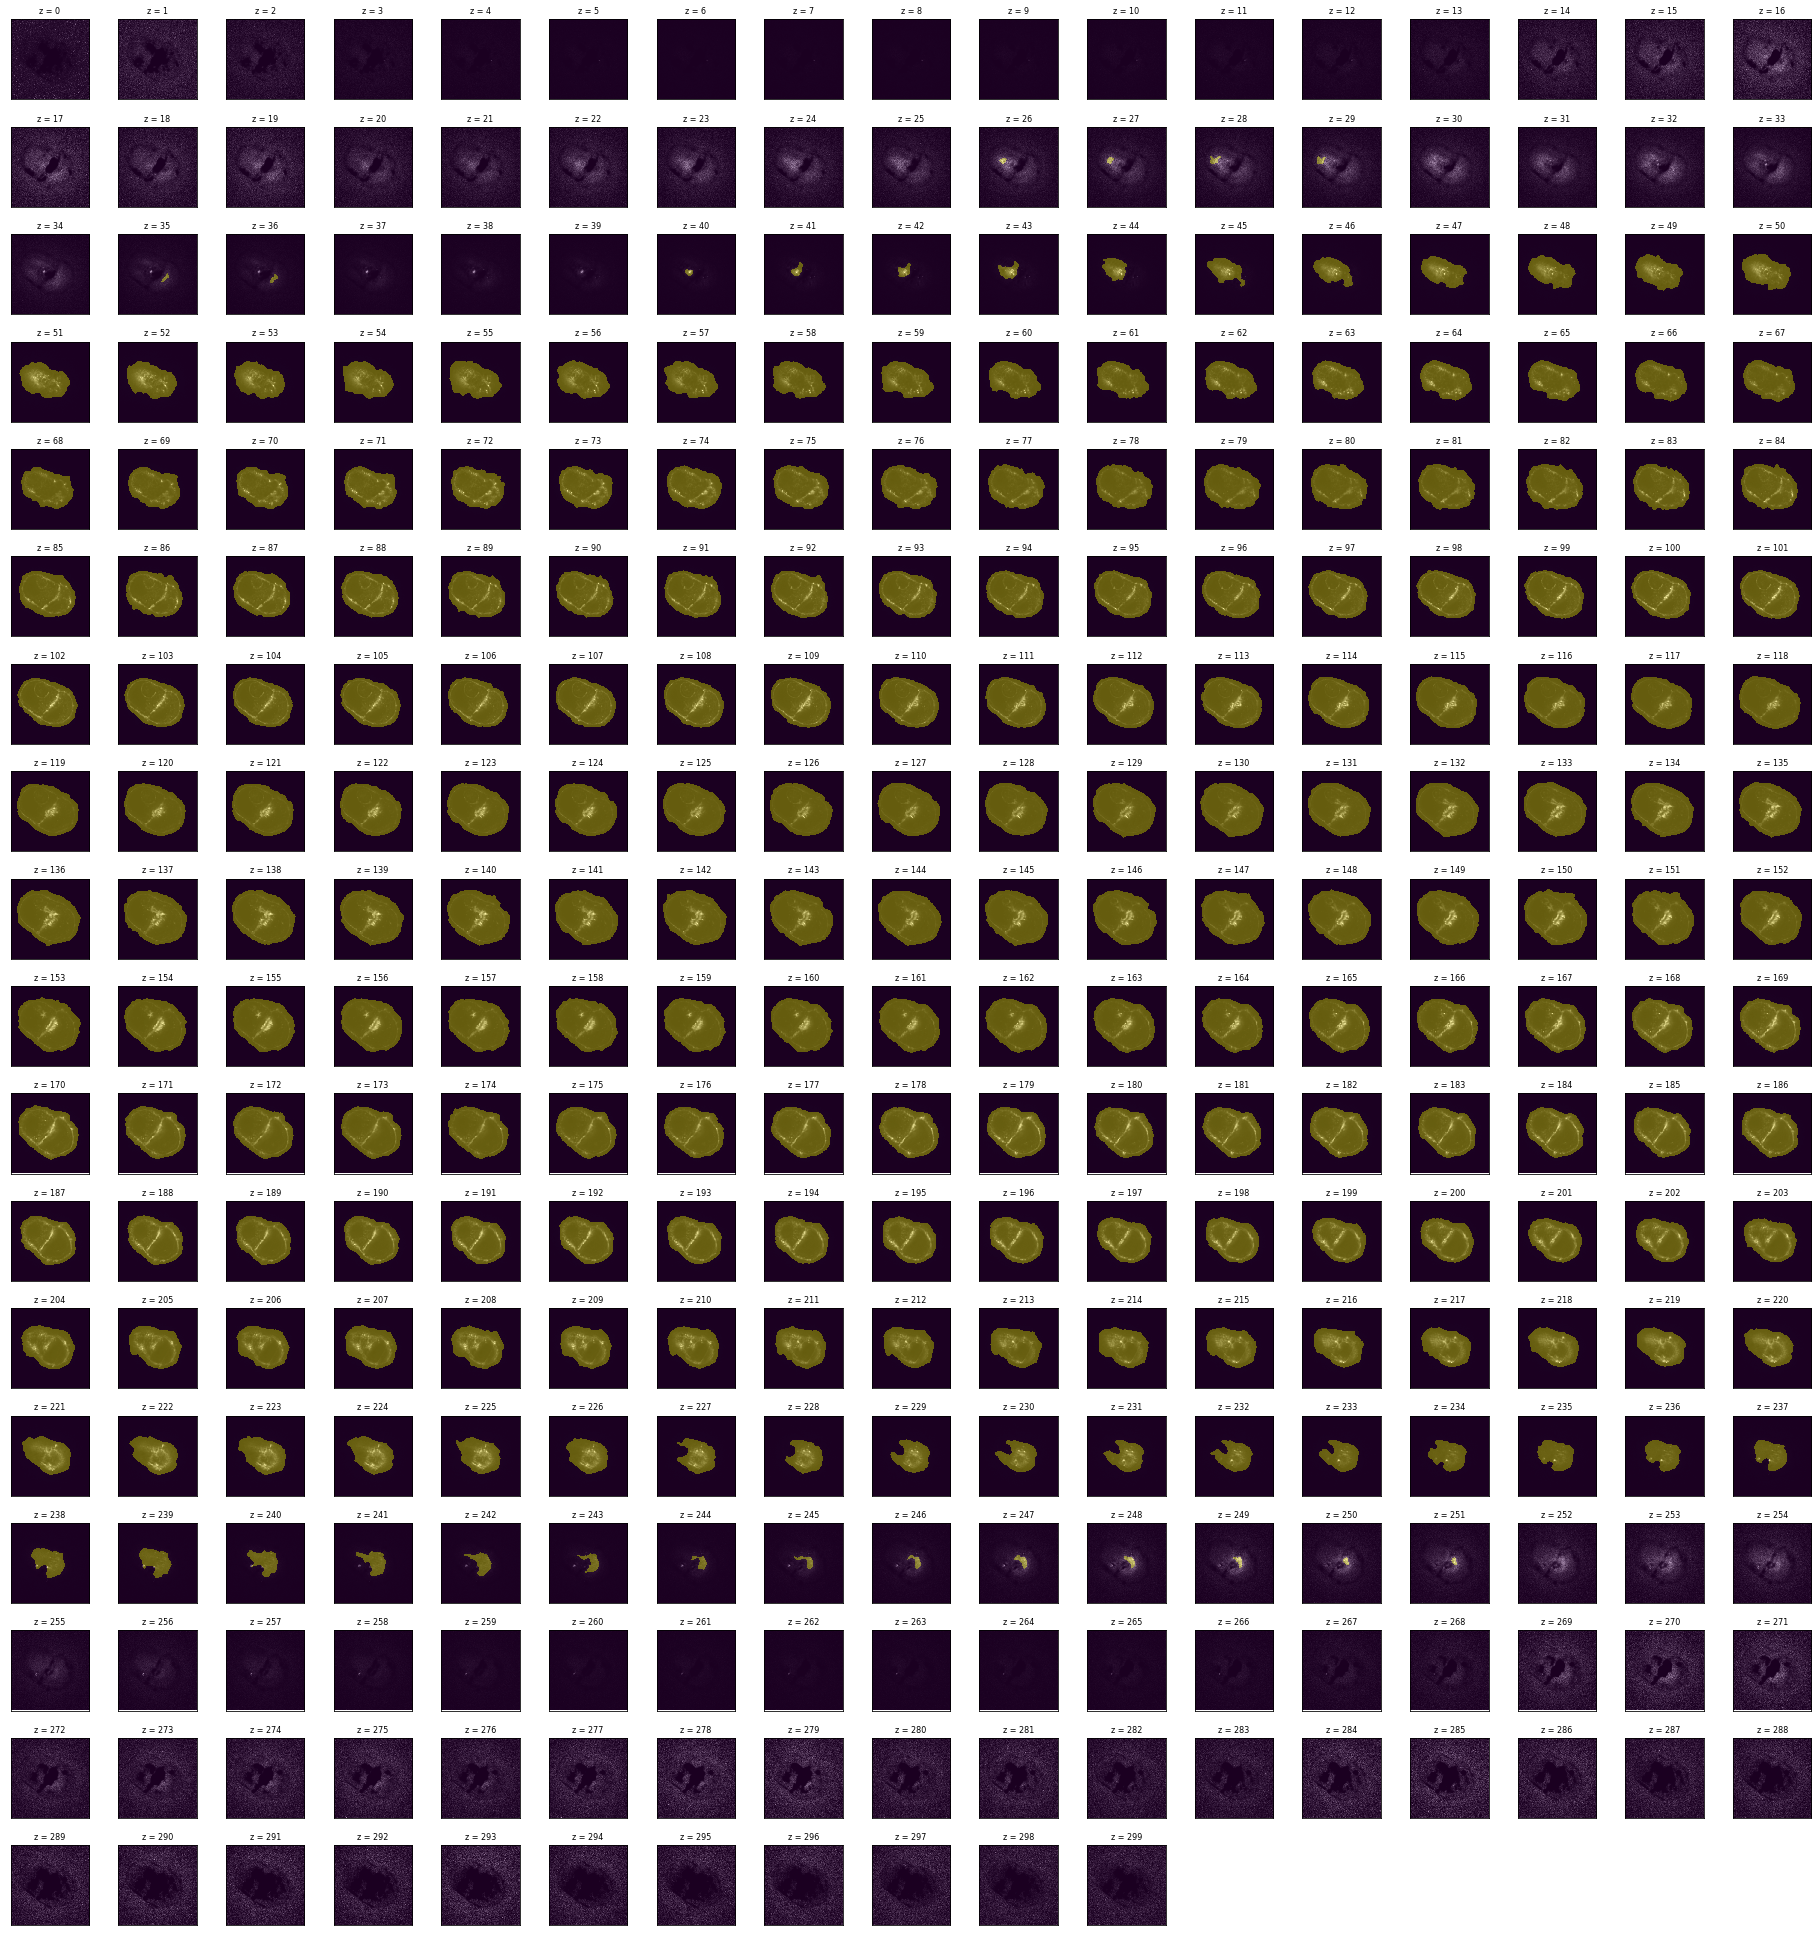

In [29]:
cyst = lumen_contours(cyst_stack)

# plot each z-slice of cyst contours
_ = plot_stack_save(cyst, pw=output_dir, name=filename_t + '_cyst_segContours_CGV',
                subtitle=True)
_ = plot_stack_overlay(cyst, z_stack, pw=output_dir,
                   name=filename_t + '_cyst_segContours_overlay', subtitle=True)

#### LUMEN & CYST: post-contour processing

Is post lumen procesing necessary? (y/n) y


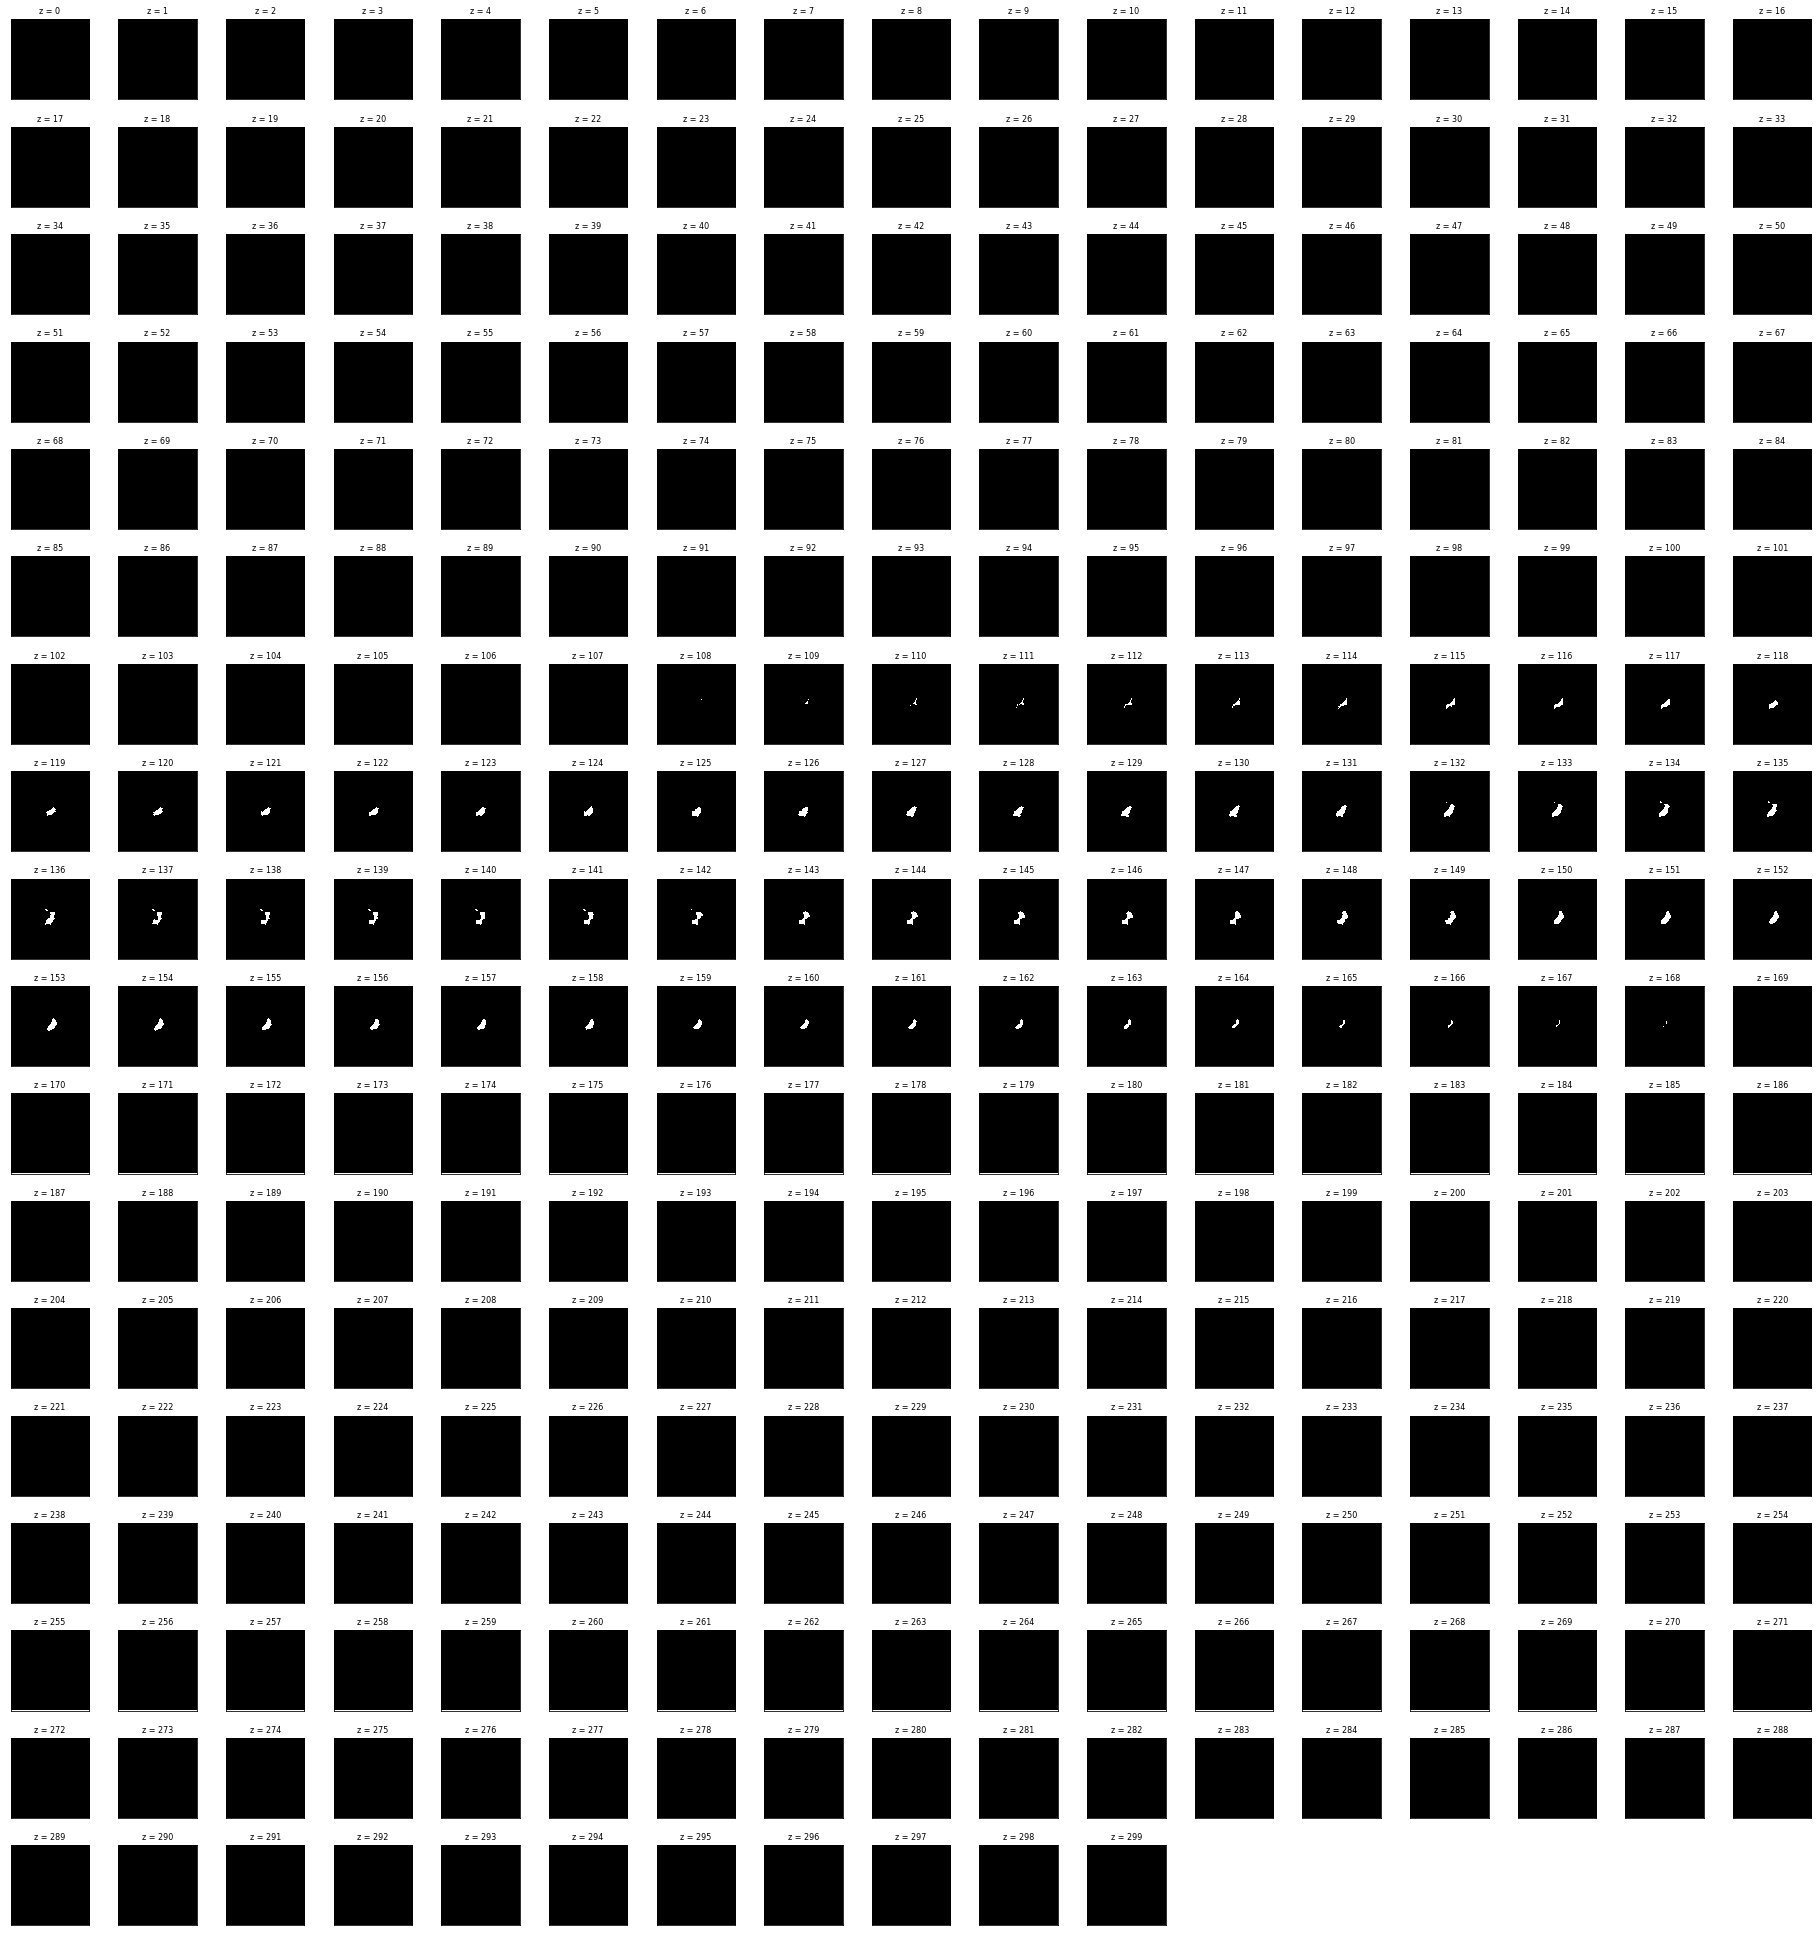

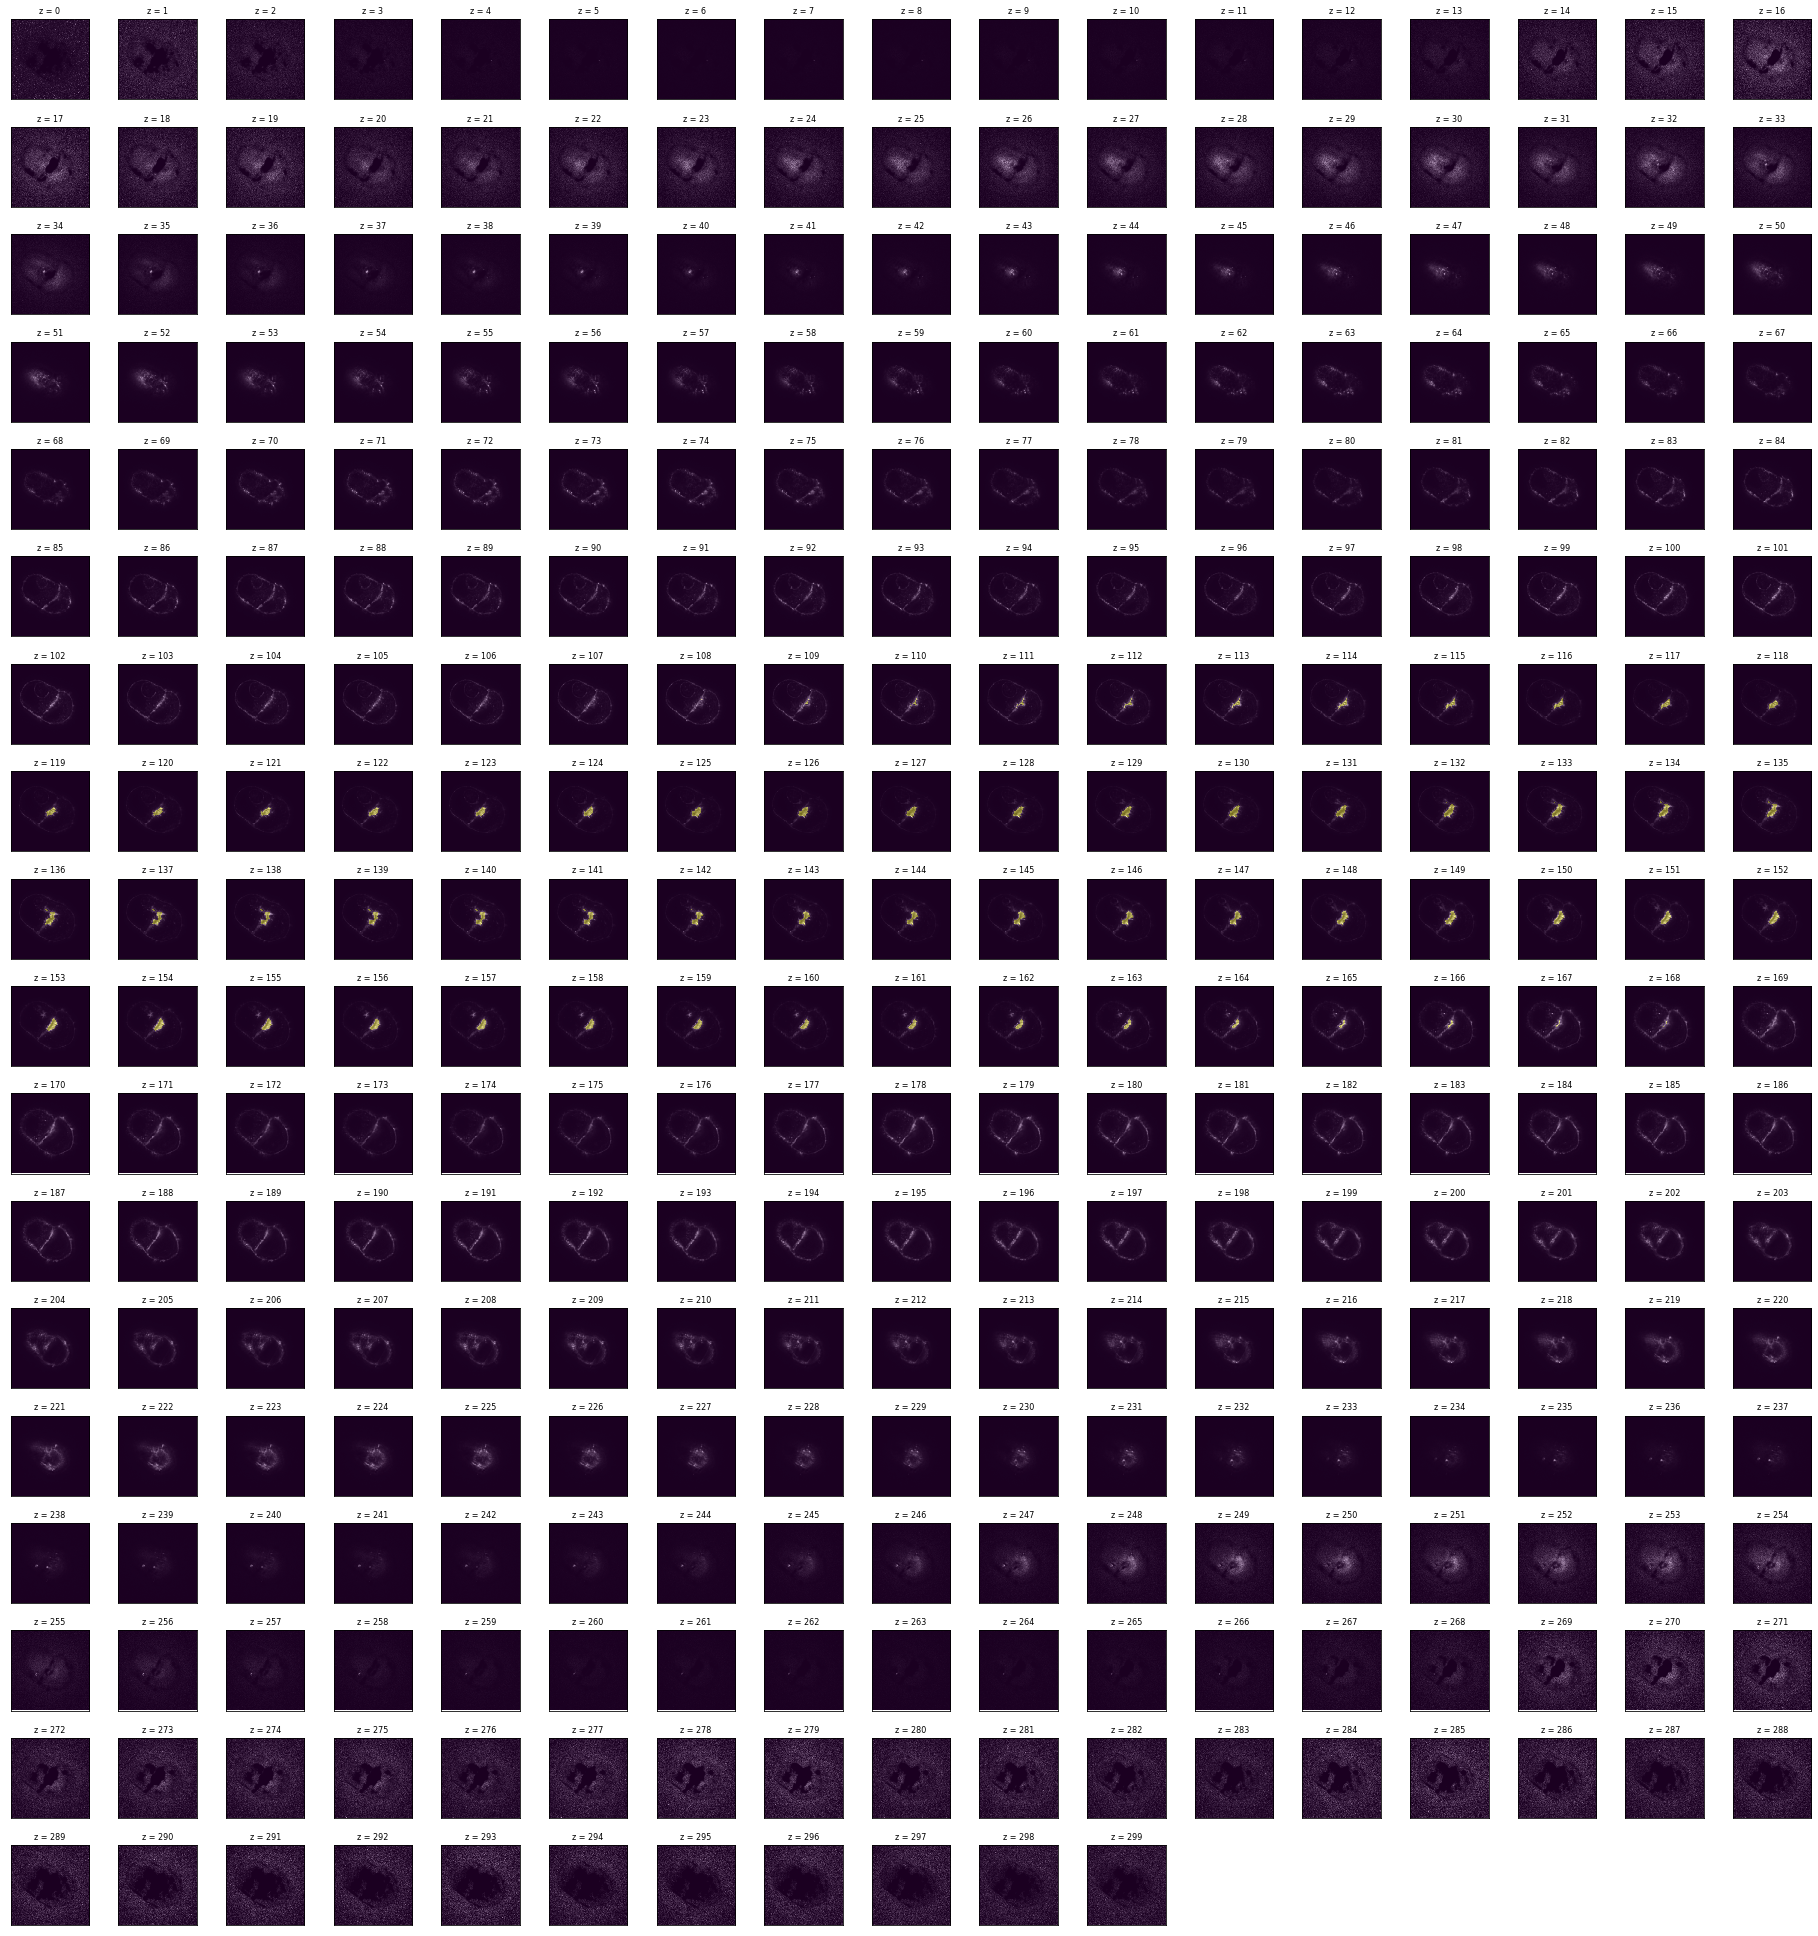

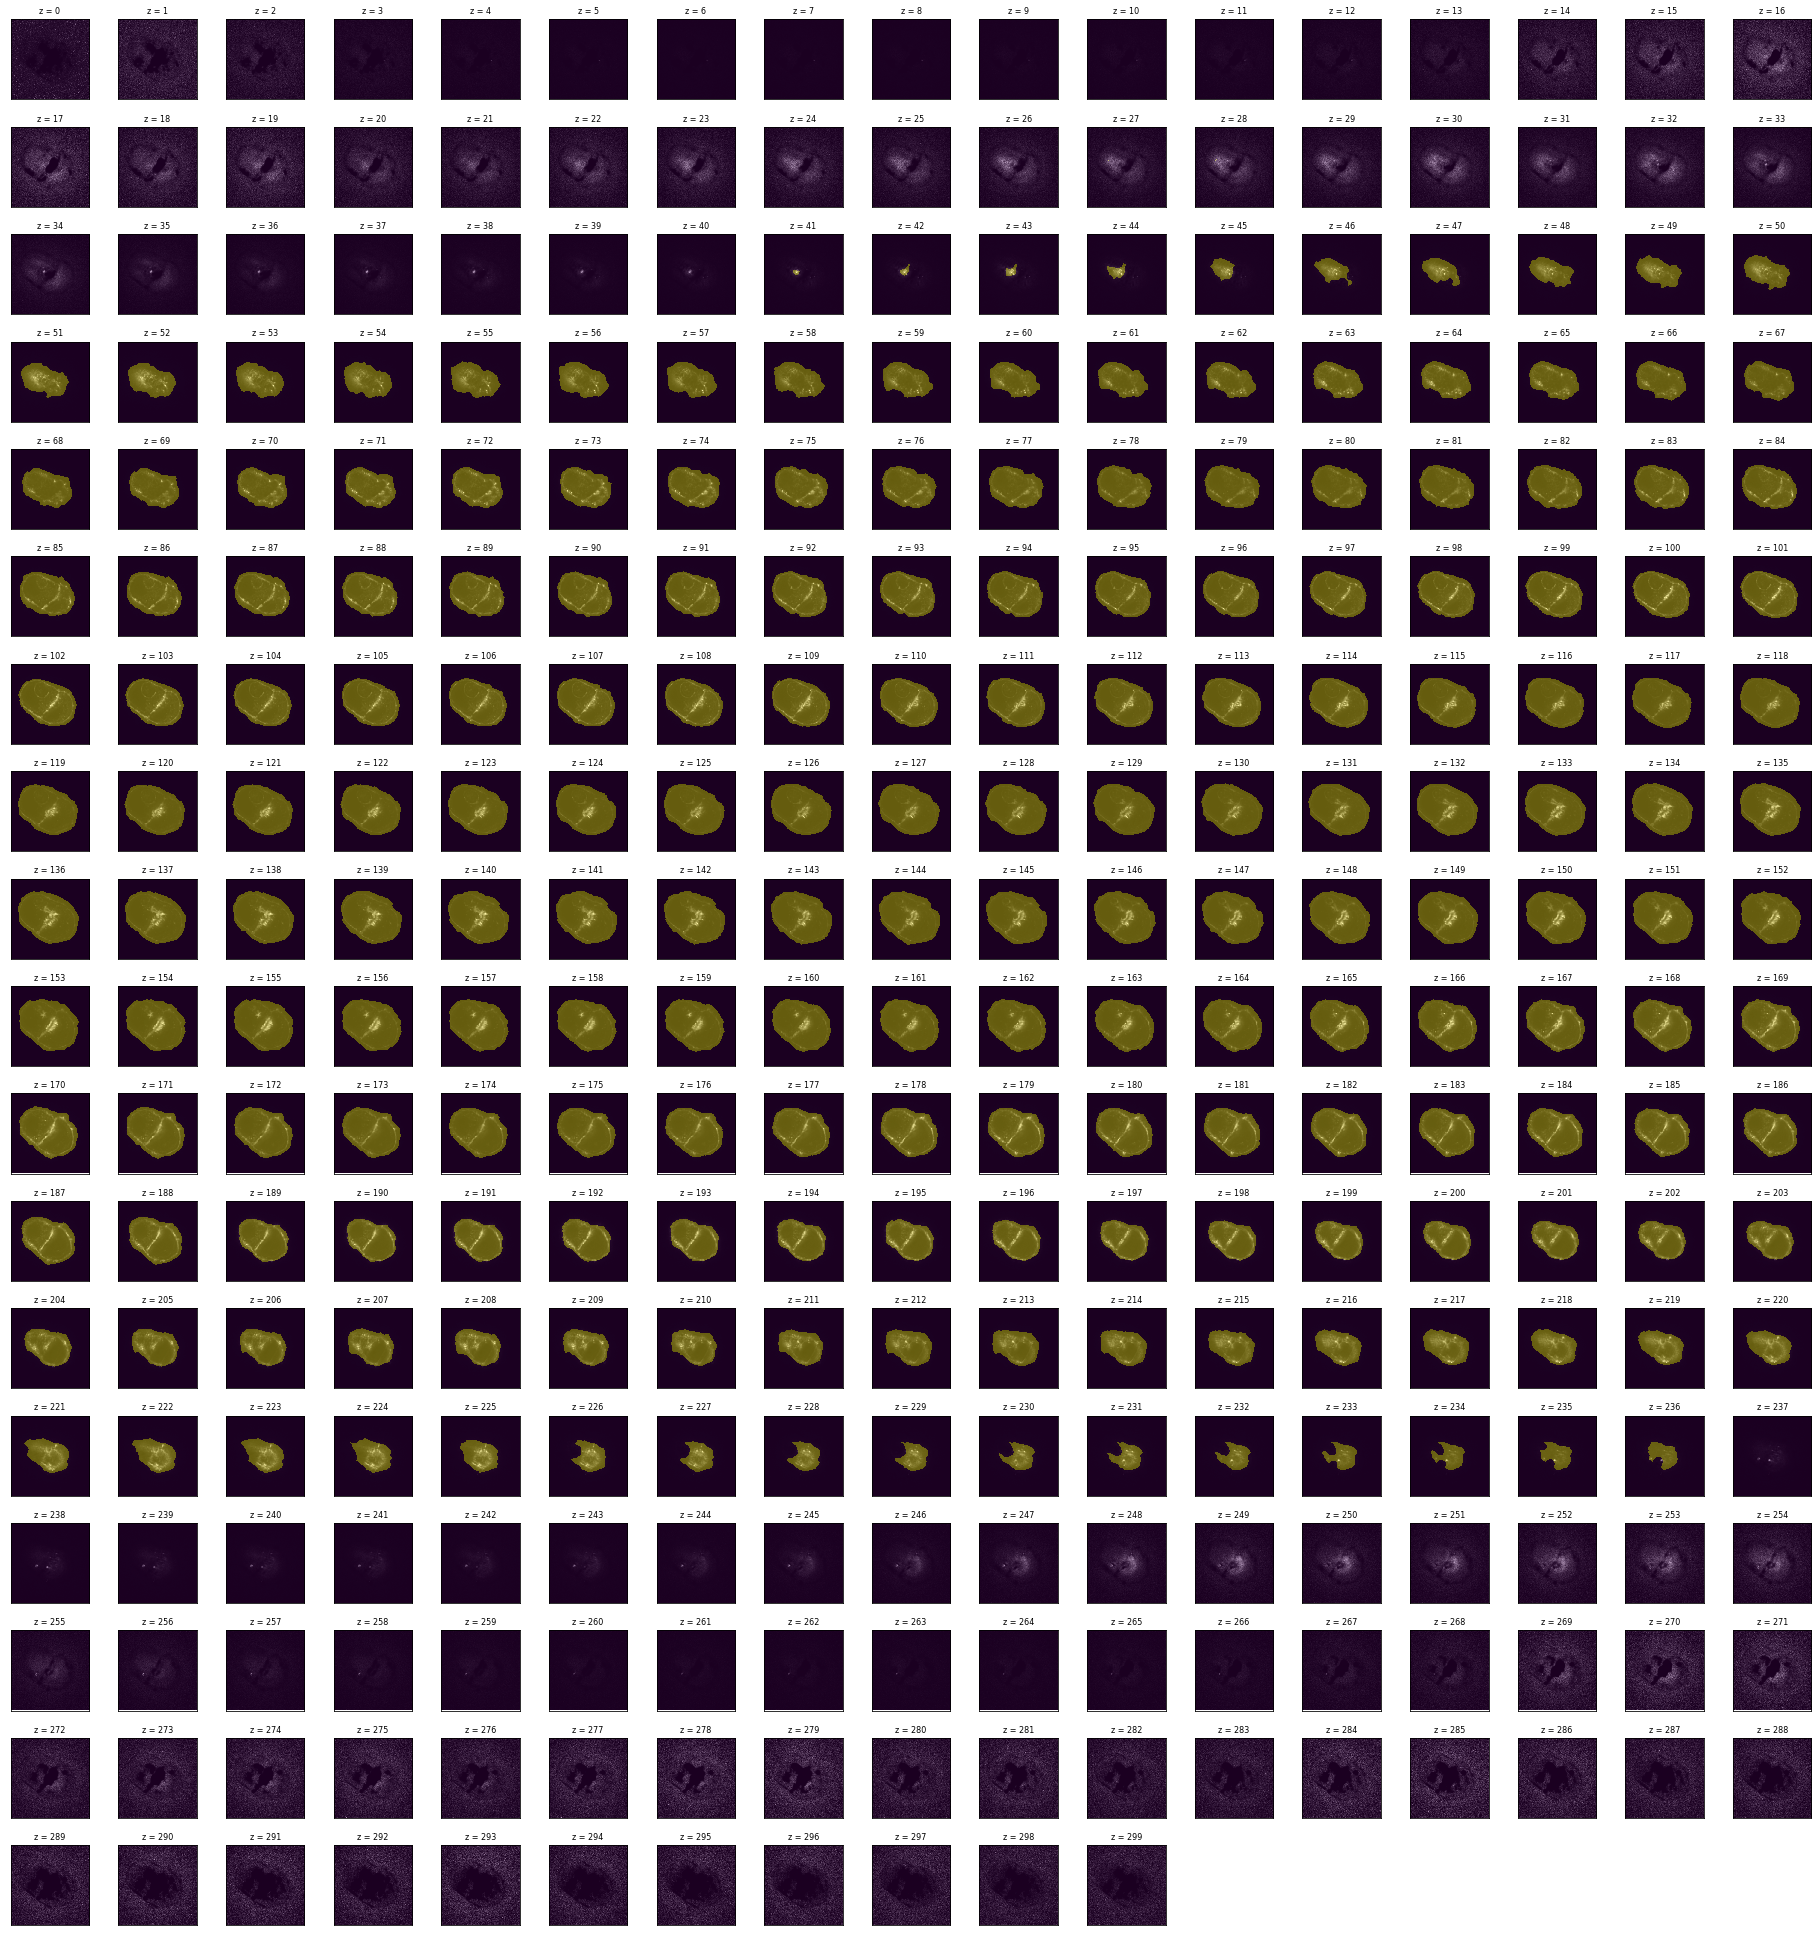

In [30]:
# lumen post contour processing
lum_post = input('Is post lumen procesing necessary? (y/n) ')
if lum_post == 'y':
    lumen1 = lumen_post(lumen, disk_size=7)
    _ = plot_stack_save(lumen1, pw=output_dir,
                    name=filename_t + '_segContoursPostProcs_CGV',
                    subtitle=True)
    _ = plot_stack_overlay(lumen1, z_stack, pw=output_dir,
                   name=filename_t + '_segContoursPostProcs_overlay', subtitle=True)
else:
    lumen1 = np.copy(lumen)
    
# cyst post contour processing
cyst1 = cyst_post(cyst,3)
_ = plot_stack_overlay(cyst1, z_stack, pw=output_dir,
                   name=filename_t + '_cyst_segContoursPostProcs_overlay',
                   subtitle=True)


#### save segmented lumen  and cyst as tiff file for use in curvature analysis
Note: I check how the segmentaiton is in the filename_t_raw_seg.tif overlay stack in Fiji. If I need to do any manual adjustments I resave the lumen channel as filename_t.tif and the cyst channel as filename_t_cyst.tif

In [31]:
io.imsave(output_dir + filename_t + '.tif', lumen1)
io.imsave(output_dir + filename_t + '_cyst.tif', cyst1)

# %% save multi-channel image with raw and segmented lumen & segmented cyst
lumen_stack = np.array(io.imread(output_dir + filename_t + '.tif'),
                       dtype=np.uint16)
cyst_stack = np.array(io.imread(output_dir + filename_t + '_cyst.tif'),
                      dtype=np.uint16)
all_stack = np.stack((z_stack, lumen_stack, cyst_stack),
                     axis=1).transpose((0, 2, 3, 1)).astype(np.int16)
io.imsave(output_dir + filename_t + '_raw_seg.tif', all_stack)

/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_3D/output/190418_09/seg/190418_09_t01.tif is a low contrast image
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_3D/output/190418_09/seg/190418_09_t01_cyst.tif is a low contrast image
  
/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_3D/output/190418_09/seg/190418_09_t01_raw_seg.tif is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
